In [2]:
!pip install vllm

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 264.6/264.6 MB 5.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 96.5/96.5 kB 9.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 71.6/71.6 kB 7.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 111.0/111.0 kB 12.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 87.6/87.6 kB 9.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 67.0/67.0 MB 12.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 906.5/906.5 MB 1.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 3.4/3.4 MB 90.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.2/7.2 MB 115.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 16.7/16.7 MB 79.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 396.9/396.9 kB 34.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 3.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13

In [1]:
import time
import json
import os
import gc
import subprocess
import torch
import numpy as np
from vllm import LLM, SamplingParams

# Set CUDA paths
os.environ["CUDA_HOME"] = "/usr/local/cuda-11.8"
os.environ["LD_LIBRARY_PATH"] += ":/usr/local/cuda-11.8/lib64"

# Function to get GPU memory usage (in MB)
def get_memory_usage_vllm():
    """Extract GPU memory usage (in MB) from nvidia-smi"""
    try:
        output = subprocess.check_output(["nvidia-smi", "--query-gpu=memory.used", "--format=csv,nounits,noheader"])
        memory_used = int(output.decode("utf-8").strip().split("\n")[0])  # Extract memory usage from first GPU
        return memory_used
    except Exception as e:
        print("Error fetching memory usage:", e)
        return 0

# Track model loading time
start_load = time.time()
model_name = "facebook/opt-125m"
llm = LLM(model=model_name, dtype="float16")
load_time = time.time() - start_load
print(f"Model loaded in {load_time:.2f} seconds.")

# Function to run inference on vLLM
def run_inference_vllm(prompts, token_sizes, num_runs=5):
    results = []

    for prompt in prompts:
        for tokens in token_sizes:
            latencies, memory_usage, throughput_vals = [], [], []

            for _ in range(num_runs):
                gc.collect()  # Clean up memory

                # Measure memory before inference
                start_mem = get_memory_usage_vllm()

                sampling_params = SamplingParams(max_tokens=tokens)
                start_time = time.time()

                # Run inference
                outputs = llm.generate([prompt], sampling_params)

                # Measure inference time
                inference_time = time.time() - start_time
                peak_mem = get_memory_usage_vllm()

                # Extract generated tokens count
                tokens_generated = sum(len(output.outputs[0].token_ids) for output in outputs)

                # Store performance metrics
                latencies.append(inference_time)
                memory_usage.append(peak_mem - start_mem)  # Memory difference
                throughput_vals.append(tokens_generated / inference_time if inference_time > 0 else 0)

            # Store aggregated results
            results.append({
                "method": "vLLM",
                "tokens": tokens,
                "latency_mean": np.mean(latencies),
                "latency_std": np.std(latencies),
                "peak_memory_usage": max(memory_usage),
                "throughput_mean": np.mean(throughput_vals),
                "batch_size": len(prompts),
                "model_load_time": load_time
            })

    return results

# Run inference tests
prompts = ["Explain in detail about the string theory"]
token_sizes = [10, 50, 100, 200, 500, 1000, 1500]
results_vllm = run_inference_vllm(prompts, token_sizes)

# Save results to JSON
with open("vllm_results.json", "w") as f:
    json.dump(results_vllm, f, indent=4)

print("vLLM Inference Completed.")
print(json.dumps(results_vllm, indent=4))

INFO 03-15 02:59:22 __init__.py:207] Automatically detected platform cuda.


/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


config.json:   0%|          | 0.00/651 [00:00<?, ?B/s]

INFO 03-15 02:59:37 config.py:549] This model supports multiple tasks: {'embed', 'classify', 'score', 'reward', 'generate'}. Defaulting to 'generate'.
INFO 03-15 02:59:37 llm_engine.py:234] Initializing a V0 LLM engine (v0.7.3) with config: model='facebook/opt-125m', speculative_config=None, tokenizer='facebook/opt-125m', skip_tokenizer_init=False, tokenizer_mode=auto, revision=None, override_neuron_config=None, tokenizer_revision=None, trust_remote_code=False, dtype=torch.float16, max_seq_len=2048, download_dir=None, load_format=LoadFormat.AUTO, tensor_parallel_size=1, pipeline_parallel_size=1, disable_custom_all_reduce=False, quantization=None, enforce_eager=False, kv_cache_dtype=auto,  device_config=cuda, decoding_config=DecodingConfig(guided_decoding_backend='xgrammar'), observability_config=ObservabilityConfig(otlp_traces_endpoint=None, collect_model_forward_time=False, collect_model_execute_time=False), seed=0, served_model_name=facebook/opt-125m, num_scheduler_steps=1, multi_ste

tokenizer_config.json:   0%|          | 0.00/685 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/441 [00:00<?, ?B/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

INFO 03-15 02:59:41 cuda.py:178] Cannot use FlashAttention-2 backend for Volta and Turing GPUs.
INFO 03-15 02:59:41 cuda.py:226] Using XFormers backend.
INFO 03-15 02:59:42 model_runner.py:1110] Starting to load model facebook/opt-125m...
INFO 03-15 02:59:43 weight_utils.py:254] Using model weights format ['*.bin']


pytorch_model.bin:   0%|          | 0.00/251M [00:00<?, ?B/s]

INFO 03-15 02:59:44 weight_utils.py:270] Time spent downloading weights for facebook/opt-125m: 1.400574 seconds


Loading pt checkpoint shards:   0% Completed | 0/1 [00:00<?, ?it/s]


INFO 03-15 02:59:45 model_runner.py:1115] Loading model weights took 0.2389 GB
INFO 03-15 02:59:46 worker.py:267] Memory profiling takes 1.03 seconds
INFO 03-15 02:59:46 worker.py:267] the current vLLM instance can use total_gpu_memory (14.74GiB) x gpu_memory_utilization (0.90) = 13.27GiB
INFO 03-15 02:59:46 worker.py:267] model weights take 0.24GiB; non_torch_memory takes 0.03GiB; PyTorch activation peak memory takes 0.47GiB; the rest of the memory reserved for KV Cache is 12.53GiB.
INFO 03-15 02:59:47 executor_base.py:111] # cuda blocks: 22813, # CPU blocks: 7281
INFO 03-15 02:59:47 executor_base.py:116] Maximum concurrency for 2048 tokens per request: 178.23x
INFO 03-15 02:59:52 model_runner.py:1434] Capturing cudagraphs for decoding. This may lead to unexpected consequences if the model is not static. To run the model in eager mode, set 'enforce_eager=True' or use '--enforce-eager' in the CLI. If out-of-memory error occurs during cudagraph capture, consider decreasing `gpu_memory_u

Capturing CUDA graph shapes: 100%|██████████| 35/35 [00:29<00:00,  1.19it/s]

INFO 03-15 03:00:21 model_runner.py:1562] Graph capturing finished in 29 secs, took 0.14 GiB
INFO 03-15 03:00:21 llm_engine.py:436] init engine (profile, create kv cache, warmup model) took 36.18 seconds


Model loaded in 60.51 seconds.


Processed prompts: 100%|██████████| 1/1 [00:04<00:00,  4.21s/it, est. speed input: 2.14 toks/s, output: 356.63 toks/s]

vLLM Inference Completed.
[
    {
        "method": "vLLM",
        "tokens": 10,
        "latency_mean": 0.060081768035888675,
        "latency_std": 0.007072247948376164,
        "peak_memory_usage": 0,
        "throughput_mean": 168.81412040952046,
        "batch_size": 1,
        "model_load_time": 60.50885844230652
    },
    {
        "method": "vLLM",
        "tokens": 50,
        "latency_mean": 0.17364826202392578,
        "latency_std": 0.02258201697761848,
        "peak_memory_usage": 0,
        "throughput_mean": 290.11661902903825,
        "batch_size": 1,
        "model_load_time": 60.50885844230652
    },
    {
        "method": "vLLM",
        "tokens": 100,
        "latency_mean": 0.17772693634033204,
        "latency_std": 0.09997217392255378,
        "peak_memory_usage": 0,
        "throughput_mean": 319.52590096049573,
        "batch_size": 1,
        "model_load_time": 60.50885844230652
    },
    {
        "method": "vLLM",
        "tokens": 200,
        "latency_

In [2]:
import json
import matplotlib.pyplot as plt
import pandas as pd

# Load results
with open("hft_results.json") as f:
    hft_data = json.load(f)
with open("vllm_results.json") as f:
    vllm_data = json.load(f)

# Create DataFrame
df = pd.DataFrame(hft_data + vllm_data)

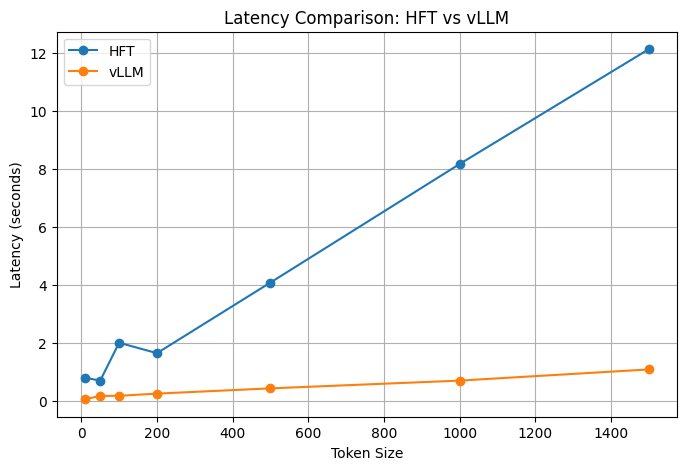

In [3]:
# Plot Latency
plt.figure(figsize=(8, 5))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset["tokens"], subset["latency_mean"], marker="o", label=method)

plt.xlabel("Token Size")
plt.ylabel("Latency (seconds)")
plt.title("Latency Comparison: HFT vs vLLM")
plt.legend()
plt.grid()
plt.show()



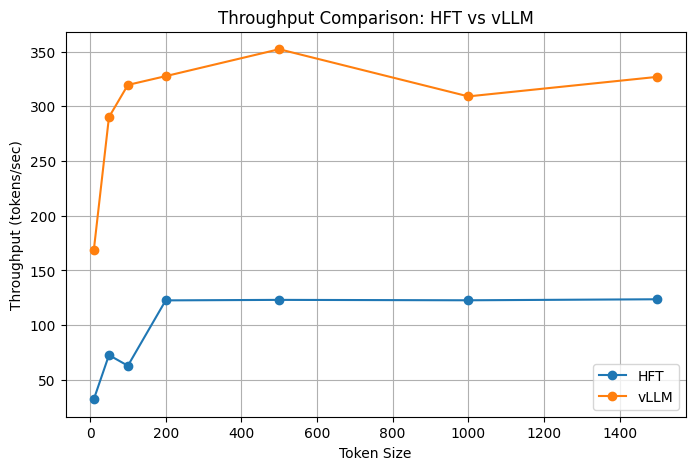

In [4]:
# Plot Throughput
plt.figure(figsize=(8, 5))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset["tokens"], subset["throughput_mean"], marker="o", label=method)

plt.xlabel("Token Size")
plt.ylabel("Throughput (tokens/sec)")
plt.title("Throughput Comparison: HFT vs vLLM")
plt.legend()
plt.grid()
plt.show()


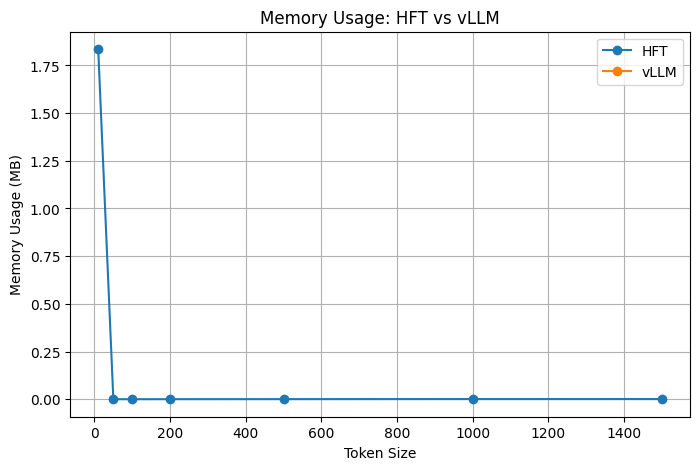

In [5]:
# Plot Memory Usage
plt.figure(figsize=(8, 5))
for method in df["method"].unique():
    subset = df[df["method"] == method]
    plt.plot(subset["tokens"], subset["memory_usage_mean"], marker="o", label=method)

plt.xlabel("Token Size")
plt.ylabel("Memory Usage (MB)")
plt.title("Memory Usage: HFT vs vLLM")
plt.legend()
plt.grid()
plt.show()

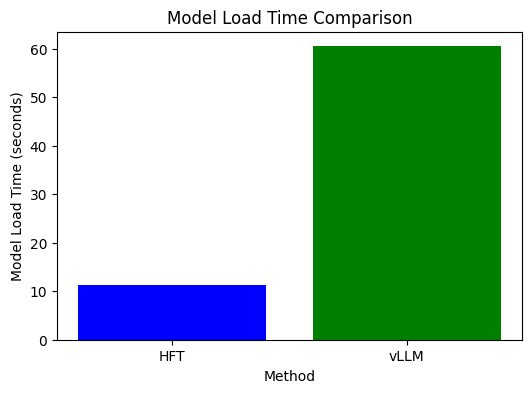

In [6]:
# Model Loading Time
plt.figure(figsize=(6, 4))
methods = df["method"].unique()
load_times = [df[df["method"] == m]["model_load_time"].values[0] for m in methods]

plt.bar(methods, load_times, color=["blue", "green"])
plt.xlabel("Method")
plt.ylabel("Model Load Time (seconds)")
plt.title("Model Load Time Comparison")
plt.show()

In [7]:
!pip install dash jupyter-dash plotly pandas matplotlib


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 104.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 10.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 228.0/228.0 kB 22.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 67.0 MB/s eta 0:00:00
  Attempting uninstall: Werkzeug
    Found existing installation: Werkzeug 3.1.3
    Uninstalling Werkzeug-3.1.3:
      Successfully uninstalled Werkzeug-3.1.3
  Attempting uninstall: Flask
    Found existing installation: Flask 3.1.0
    Uninstalling Flask-3.1.0:
      Successfully uninstalled Flask-3.1.0


In [1]:
import warnings
warnings.filterwarnings('ignore')
import json
import plotly.graph_objects as go
import pandas as pd
from jupyter_dash import JupyterDash
import dash_core_components as dcc
import dash_html_components as html

# Load results
with open("hft_results.json") as f:
    hft_data = json.load(f)
with open("vllm_results.json") as f:
    vllm_data = json.load(f)

# Create DataFrame
df = pd.DataFrame(hft_data + vllm_data)

# Dash app setup
app = JupyterDash(__name__)

# Latency Plot
latency_fig = go.Figure()
for method in df["method"].unique():
    subset = df[df["method"] == method]
    latency_fig.add_trace(go.Scatter(x=subset["tokens"], y=subset["latency_mean"],
                                    mode='markers+lines', name=method))

latency_fig.update_layout(title="Latency Comparison: HFT vs vLLM",
                          xaxis_title="Token Size",
                          yaxis_title="Latency (seconds)",
                          template="plotly")

# Throughput Plot
throughput_fig = go.Figure()
for method in df["method"].unique():
    subset = df[df["method"] == method]
    throughput_fig.add_trace(go.Scatter(x=subset["tokens"], y=subset["throughput_mean"],
                                       mode='markers+lines', name=method))

throughput_fig.update_layout(title="Throughput Comparison: HFT vs vLLM",
                             xaxis_title="Token Size",
                             yaxis_title="Throughput (tokens/sec)",
                             template="plotly")

# Memory Usage Plot
memory_usage_fig = go.Figure()
for method in df["method"].unique():
    subset = df[df["method"] == method]
    memory_usage_fig.add_trace(go.Scatter(x=subset["tokens"], y=subset["memory_usage_mean"],
                                         mode='markers+lines', name=method))

memory_usage_fig.update_layout(title="Memory Usage: HFT vs vLLM",
                               xaxis_title="Token Size",
                               yaxis_title="Memory Usage (MB)",
                               template="plotly")

# Model Loading Time Plot
load_times = [df[df["method"] == m]["model_load_time"].values[0] for m in df["method"].unique()]
load_times_fig = go.Figure([go.Bar(x=df["method"].unique(), y=load_times)])

load_times_fig.update_layout(title="Model Load Time Comparison",
                             xaxis_title="Method",
                             yaxis_title="Model Load Time (seconds)",
                             template="plotly")

# App Layout
app.layout = html.Div(
    children=[
        html.H1("Model Performance Dashboard", style={'textAlign': 'center'}),

        html.Div(
            children=[
                html.Div(
                    children=dcc.Graph(figure=latency_fig),
                    style={'width': '48%', 'display': 'inline-block', 'padding': '0 10px'}
                ),
                html.Div(
                    children=dcc.Graph(figure=throughput_fig),
                    style={'width': '48%', 'display': 'inline-block', 'padding': '0 10px'}
                ),
            ],
            style={'display': 'flex', 'justify-content': 'space-between', 'marginBottom': '20px'}
        ),

        html.Div(
            children=[
                html.Div(
                    children=dcc.Graph(figure=memory_usage_fig),
                    style={'width': '48%', 'display': 'inline-block', 'padding': '0 10px'}
                ),
                html.Div(
                    children=dcc.Graph(figure=load_times_fig),
                    style={'width': '48%', 'display': 'inline-block', 'padding': '0 10px'}
                ),
            ],
            style={'display': 'flex', 'justify-content': 'space-between'}
        ),
    ]
)

# Run the app
app.run_server(mode="inline", debug=True)


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>